In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
X_train=np.loadtxt('training_data/Xtrain_seg_mask.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_seg_mask.csv',delimiter=',')
#X_trainl=np.loadtxt('training_data/Xtrainl_av_gl6000.csv',delimiter=',')

#X_train=X_train[:,250:550]
arr=np.arange(0,len(X_train),1)
np.random.shuffle(arr)

#X_extra=np.loadtxt('training_data/Xextra_av_stitch.csv',delimiter=',')
#X_train=preprocessing.normalize(X_train)
#X_train=X_train[:,150:350]
#scalar=preprocessing.StandardScaler()
#scalar.fit(X_train)
#X_train=scalar.transform(X_train)
#X_train=X_train
#X_train=np.array([[el[i] for i in range(0,len(el),2)] for el in X_train])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size=0.2)
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(1639, 4800) (1639, 2) (410, 4800) (410, 2)


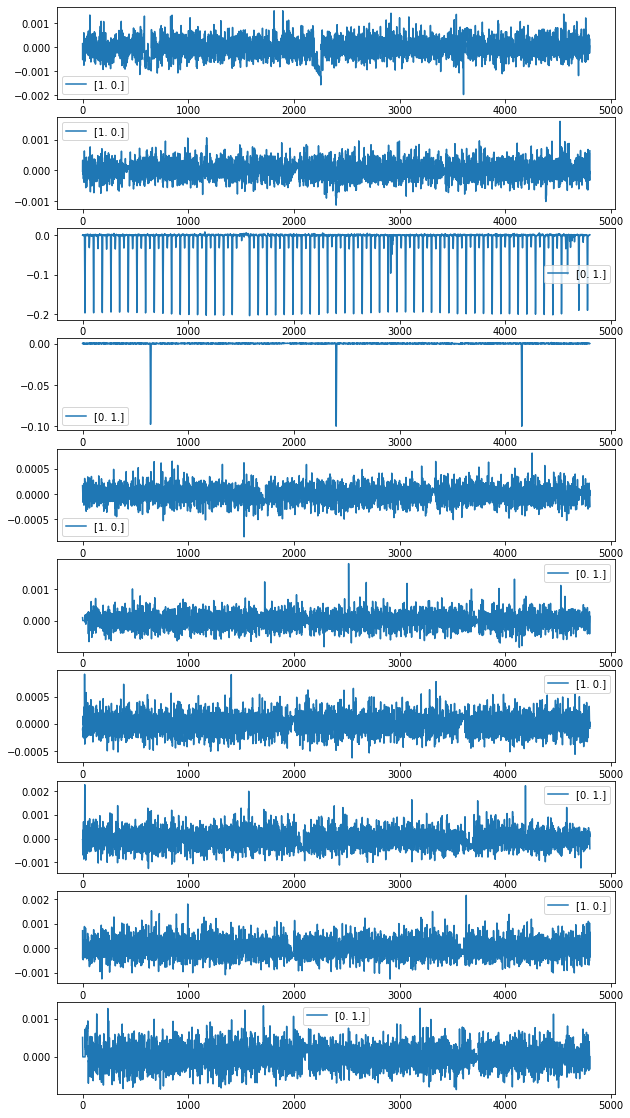

In [5]:
np.random.seed(11223)
'''
wt=[]
for el in Xtrain:
    med=np.median(el)
    min=el[np.argmin(el)]
    std=np.std(el)
    temp=(el-med)/(med-min)
    clean=[x for x in temp if x > med-std]
    wt.append(1/np.sqrt(np.std(clean)))

norm = np.linalg.norm(np.array(wt))
wt= 100*(np.array(wt)/norm)

print(wt.shape)

kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
Xtrain = [np.convolve(Xtrain[i], kernel, mode='same') for i in range(len(Xtrain))]
Xtest = [np.convolve(Xtest[i], kernel, mode='same') for i in range(len(Xtest))]
'''
#vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,1,figsize=(10,20))

#for i in range(0,10):
#    ax[i].plot(Xtrain[vararr[i]],label=(Ytrain[vararr[i]],wt[vararr[i]]))
#    ax[i].legend()
#plt.show
i=0
tab=0
while tab<10:
        
    ax[tab].plot(Xtrain[i],label=(Ytrain[i]))
    ax[tab].legend()
    tab+=1
    i+=1
    


In [8]:
def build_model(hp):
    IMG_SIZE=4800
    IM_L=200
    hp_units1 = hp.Int('units1', min_value=8, max_value=32, step=8)
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)
    hp_units4 = hp.Int('units4', min_value=64, max_value=256, step=64)
    hp_dense = hp.Int('unitsd', min_value=128, max_value=512, step=128)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.00001, 0.000001])

    conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
    x=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Conv1D(hp_units1,kernel_size=5,strides=3,activation='tanh',padding='same',name='second_conv16_5')(x)
    x=keras.layers.Conv1D(hp_units1,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(x) 

    x=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x)  #800
    x=keras.layers.Conv1D(hp_units2,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(x)
    x=keras.layers.Conv1D(hp_units2,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(x)

    x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_2')(x)  #400
    x=keras.layers.Conv1D(hp_units3,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(x)
    x=keras.layers.Conv1D(hp_units3,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(x)
    
    x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_3')(x)    #200
    x=keras.layers.Conv1D(hp_units4,kernel_size=3,strides=1,activation='tanh',padding='same',name='first_conv128_5')(x)
    x=keras.layers.Conv1D(hp_units4,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(x)
    x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_4')(x)    #100

    x = keras.layers.Flatten(name='flat_1')(x)

    x3=keras.layers.Dense(hp_dense,name='dense_layer_1',activation='relu')(x)
    x3=keras.layers.Dense(hp_dense,name='dense_layer_2',activation='relu')(x3)
    x3=keras.layers.Dense(hp_dense,name='dense_layer_3',activation='relu')(x3)

    x3=keras.layers.Dense(1,name='dense_layer_5',activation='relu')(x3)
    conv_op=keras.layers.Dense(2,name='dense_layer_6',activation='softmax')(x3)

    #convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    #convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])

    return convNN

In [9]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='tune4800',
    project_name='keras_tuner_demo'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(np.array(Xtrain), np.array(Ytrain), epochs=60, validation_split=0.2,callbacks=[stop_early])

Trial 30 Complete [00h 03m 15s]
val_accuracy: 0.6128048896789551

Best val_accuracy So Far: 0.6219512224197388
Total elapsed time: 00h 38m 44s
INFO:tensorflow:Oracle triggered exit


In [10]:
models = tuner.get_best_models(num_models=1)
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
cnn = tuner.hypermodel.build(bestHP)
H = cnn.fit(x=Xtrain, y=Ytrain, validation_split=0.2, batch_size=64, epochs=100, verbose=1)

Epoch 1/100
21/21 [==============================] - 11s 437ms/step - loss: 0.6924 - accuracy: 0.4836 - val_loss: 0.6930 - val_accuracy: 0.6098
Epoch 2/100
21/21 [==============================] - 9s 438ms/step - loss: 0.6903 - accuracy: 0.5187 - val_loss: 0.6928 - val_accuracy: 0.6159
Epoch 3/100
21/21 [==============================] - 9s 453ms/step - loss: 0.6872 - accuracy: 0.5248 - val_loss: 0.6924 - val_accuracy: 0.6128
Epoch 4/100
21/21 [==============================] - 12s 574ms/step - loss: 0.6822 - accuracy: 0.5423 - val_loss: 0.6917 - val_accuracy: 0.6159
Epoch 5/100
21/21 [==============================] - 10s 495ms/step - loss: 0.6776 - accuracy: 0.5431 - val_loss: 0.6903 - val_accuracy: 0.6189
Epoch 6/100
21/21 [==============================] - 10s 471ms/step - loss: 0.6739 - accuracy: 0.5469 - val_loss: 0.6893 - val_accuracy: 0.6128
Epoch 7/100
21/21 [==============================] - 10s 483ms/step - loss: 0.6721 - accuracy: 0.5469 - val_loss: 0.6882 - val_accuracy: 0

In [1]:

#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=40, verbose=VERBOSE, validation_split=0.12,callbacks=[es_callback])
#history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=50 , verbose=1 , shuffle=True,validation_split=0.2)
print(" ")

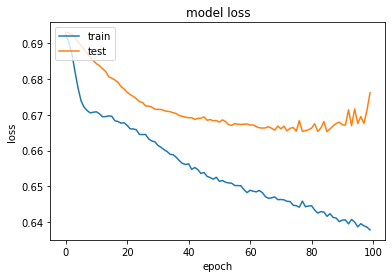

In [11]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Mloss_opt_rebin.png')
plt.show()

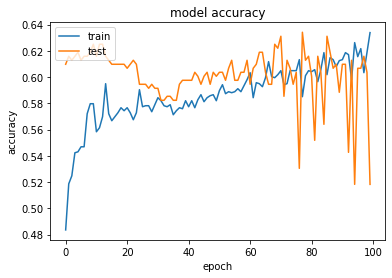

In [12]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('macc_opt_rebin.png')
plt.show()

In [18]:
test_loss, test_acc = convNN.evaluate(np.array(Xtest), np.array(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=convNN.predict(np.array(Xtest))
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)
#from sklearn.metrics import mean_squared_error
#pred_op=convNN.predict(np.array(Xtest))
#[print(Xextra_ts[i,1]) for i in range(len(Xextra_ts))]
#val=mean_squared_error(pred_op, Xextra_ts[:,1], squared=False)
#print(val)
#[print(pred_op[i],Xextra_ts[i,1]) for i in range(0,50)]

21/21 [==============================] - 1s 51ms/step - loss: 0.8942 - accuracy: 0.6507
Test accuracy: 0.6506955027580261
[[187 158]
 [ 68 234]]


In [ ]:
#convNN.save_weights('conv_LocalGlobal_raw.h5')